# 🧬 BINND Complete Workflow - From Data to Decisions
This notebook demonstrates the complete workflow for DNA-DNA binding prediction using a BINND-like model. You'll be guided through:
1. Data preparation for your custom dataset.
2. Model training and evaluation.
3. Testing BINND on your own dataset
3. Prediction analysis.

## Step 0: Environment Setup ⚙️

We're assuming you've successfully set up the Conda environment and are using it as your Jupyter kernel. This initial step is crucial!
The cell below will help confirm your setup and get our inference demonstration running:

1.  First, it changes the current working directory to `ROOT_DIR`. This ensures Python can properly locate all the necessary project files and scripts for the BINND model. Think of it like making sure you're in the right folder on your computer before running a program!
2.  Next, it executes the `sample_inference.py` script. This script runs a quick test inference. If your environment is set up correctly, you should see the inference output printed below without any errors.

In [2]:
from utils.paths import ROOT_DIR
%cd $ROOT_DIR
!python inference_demo/sample_inference.py

/home/gunavaran/Downloads/BINND
Using device: cuda
Model loaded successfully from /home/gunavaran/Downloads/BINND/inference_demo/BINND.pt

--- Inference Results ---
Sequence 1: AGCGATACGCCTTAACGTCT
Sequence 2: AATGGCGAAGGGGATCGTTC
Prediction: Bound, Probability: 0.9795


## Step 1: Preparing the Datasets 📊

To get started, you'll use a sample data.csv file (included when you clone this GitHub repository) located in ROOT_DIR/data/demo/. This file must contain three columns:

1. Seq1: Represents the first DNA sequence in a pair. **5' to 3` orientation**.
2. Seq2: Represents the second DNA sequence in a pair. Important: **5' to 3` orientation**.
3. Label: Indicates whether the sequence pair is binding or non-binding. Important: While the notebook assumes these column names for direct execution, the underlying source code can be readily adapted by users familiar with Python to accommodate different naming conventions.

The provided `data.csv` file contains 100,000 sequence pairs and their corresponding labels. In this initial step, we'll split the dataset into training, validation, and testing sets using an 8:1:1 ratio, respectively.

In [9]:
from utils.data_utils import stratified_split_dataset

data_dir = ROOT_DIR / 'data' / 'demo'
input_data_path = data_dir / 'data.csv'

stratified_split_dataset(csv_file_path=input_data_path,
                         label_column_name='Label',
                         out_dir_path=data_dir,
                         val_size=0.1,
                         test_size=0.1,
                         )

train_df shape:  (800000, 3)
test_df shape:  (100000, 3)
val_df shape:  (100000, 3)


The `stratified_split_dataset` function is designed to split your dataset into training, validation, and testing sets while preserving the original class distribution of the specified `label_column_name`. This ensures that each split (train, validation, test) proportionally represents the different categories (bound and unbound) present in your `Label` column, which is crucial for robust model training and evaluation, especially with imbalanced datasets.

The function takes the `csv_file_path`, the `label_column_name` (e.g., 'Label'), an `out_dir_path` for saving, and optional `test_size` and `val_size` parameters. It then saves the resulting `train.csv`, `val.csv`, and `test.csv` files to the specified output directory. You should now find these newly generated files in your `data_dir`.

## Step 2: Model Training 🚀

With our training, validation, and testing datasets ready, we're now set to train our BINND-like model!

During training, we'll need to specify locations to save the resulting trained model (so you can reuse it later for inference) and to store the training logs. These logs are essential for tracking the model's performance, convergence, and other important metrics throughout the training process.

In [27]:
import os
data_dir = ROOT_DIR / 'data' / 'demo'
checkpoint_dir = ROOT_DIR / 'experiments' / 'checkpoints' / 'demo'
log_dir = ROOT_DIR / 'experiments' / 'logs' / 'demo'

# Check if data directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Data directory does not exist: {data_dir}")

# Create directories if they don't exist
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

For this workflow, we have two model architectures available:
1. BINND: This is the robust model fully described in the research article.
2. BINND-Lite: A more compact and lightweight version of BINND.

You can find the implementations for both of these architectures in `ROOT_DIR/src/networks/cnn.py`. For simplicity and faster execution within this notebook, we'll be using the BINND-Lite architecture.

In [11]:
network_name = "BINNDLite"
# change the network name to BINND if you want to use BINND's architecture

Before feeding our DNA sequences into the model, they need to be converted into a numerical format. We'll be using the 4xn_v2 encoding scheme for this, which is fully described in the associated research paper. You can find the implementation of this specific encoding method in  `ROOT_DIR/src/dataloader/datasets.py`.

In [12]:
encoder_name = "4xn_v2"

Since our primary goal for this immediate step is to train the model, we're setting up an important flags 🚩 here:

In [13]:
is_train = True

### Configuring Training Hyperparameters ⚙️

As the final preparation step before we kick off training, we need to configure our hyperparameters. These values are crucial as they control the learning process itself, influencing everything from how fast your model learns to how often it saves progress.

Feel free to experiment with these values as you gain more experience, as tweaking them can significantly impact model performance and training time!

Here are the hyperparameters we'll be using:
- `max_seq_length` (int): The fixed length of input DNA sequences the model expects. The current implementation only supports 20 nucleotide long sequences.
- `batch_size` (int): Number of samples processed in one go.
- `log_interval` (int): How frequently (in batches) to print intermediate training/validation progress and log to files.
- `learning_rate` (float): (Only for training) The step size for the optimizer during training.
- `num_epochs` (int): (Only for training) The total number of full passes over the training dataset.
- `patience` (int): (Only for training) For early stopping; number of epochs to wait for validation loss improvement before stopping training.

We have kept the `num_epochs` small for faster completion of this demonstration. To potentially improve your model's performance, consider increasing this value.

In [14]:
max_seq_length = 20
batch_size = 512
learning_rate = 0.0004
num_epochs = 2
patience = 2
log_interval = 5

### Launching the Training Process! 🚀
Now for the exciting part! This cell generates and executes the command that initiates the entire training process for our BINND-like model.

We're carefully assembling a command line string (cmd_args) that passes all the configurations we just set (like data paths, network choice, and hyperparameters) to our main training script (main.py).

Once constructed, we'll print the full command so you can see exactly what's being run, and then execute it. This is where your model will start learning!

In [ ]:
cmd_args = [
    "python", f"{ROOT_DIR}/main.py",
    "--data_dir", str(data_dir),
    "--checkpoint_dir", str(checkpoint_dir),
    "--log_dir", str(log_dir),
    "--network_name", network_name,
    "--encoder_name", encoder_name,
    "--max_seq_length", str(max_seq_length),
    "--batch_size", str(batch_size),
    "--log_interval", str(log_interval),
    "--learning_rate", str(learning_rate),
    "--num_epochs", str(num_epochs),
    "--patience", str(patience),
    "--is_train"
]
cmd = " ".join(cmd_args)
print(f"Running command:\n{cmd}")
os.system(cmd)

### Training Complete! 🎉
Congratulations! You've successfully trained your BINND-like model!

Your trained model that achieved the best performance during training can now be found in your `checkpoint_dir` under the name `best_model.pt`. This is the file you'll use for making future predictions!

Your `log_dir` is also now populated with several files that provide insights into your training session:
- `runtime_info.json`: A JSON file containing information about the training run, such as execution time and memory consumption.
- `train_log.csv`: A CSV file logging the training loss and accuracy per  `log_interval`.
- `val_log.csv`: A CSV file logging the validation loss and accuracy per  `log_interval`.
- `train_loss.png`: A plot visualizing the training loss over time.
- `train_accuracy.png`: A plot visualizing the training accuracy over time.
- `val_loss.png`: A plot visualizing the validation loss over time.
- `val_accuracy.png`: A plot visualizing the validation accuracy over time.

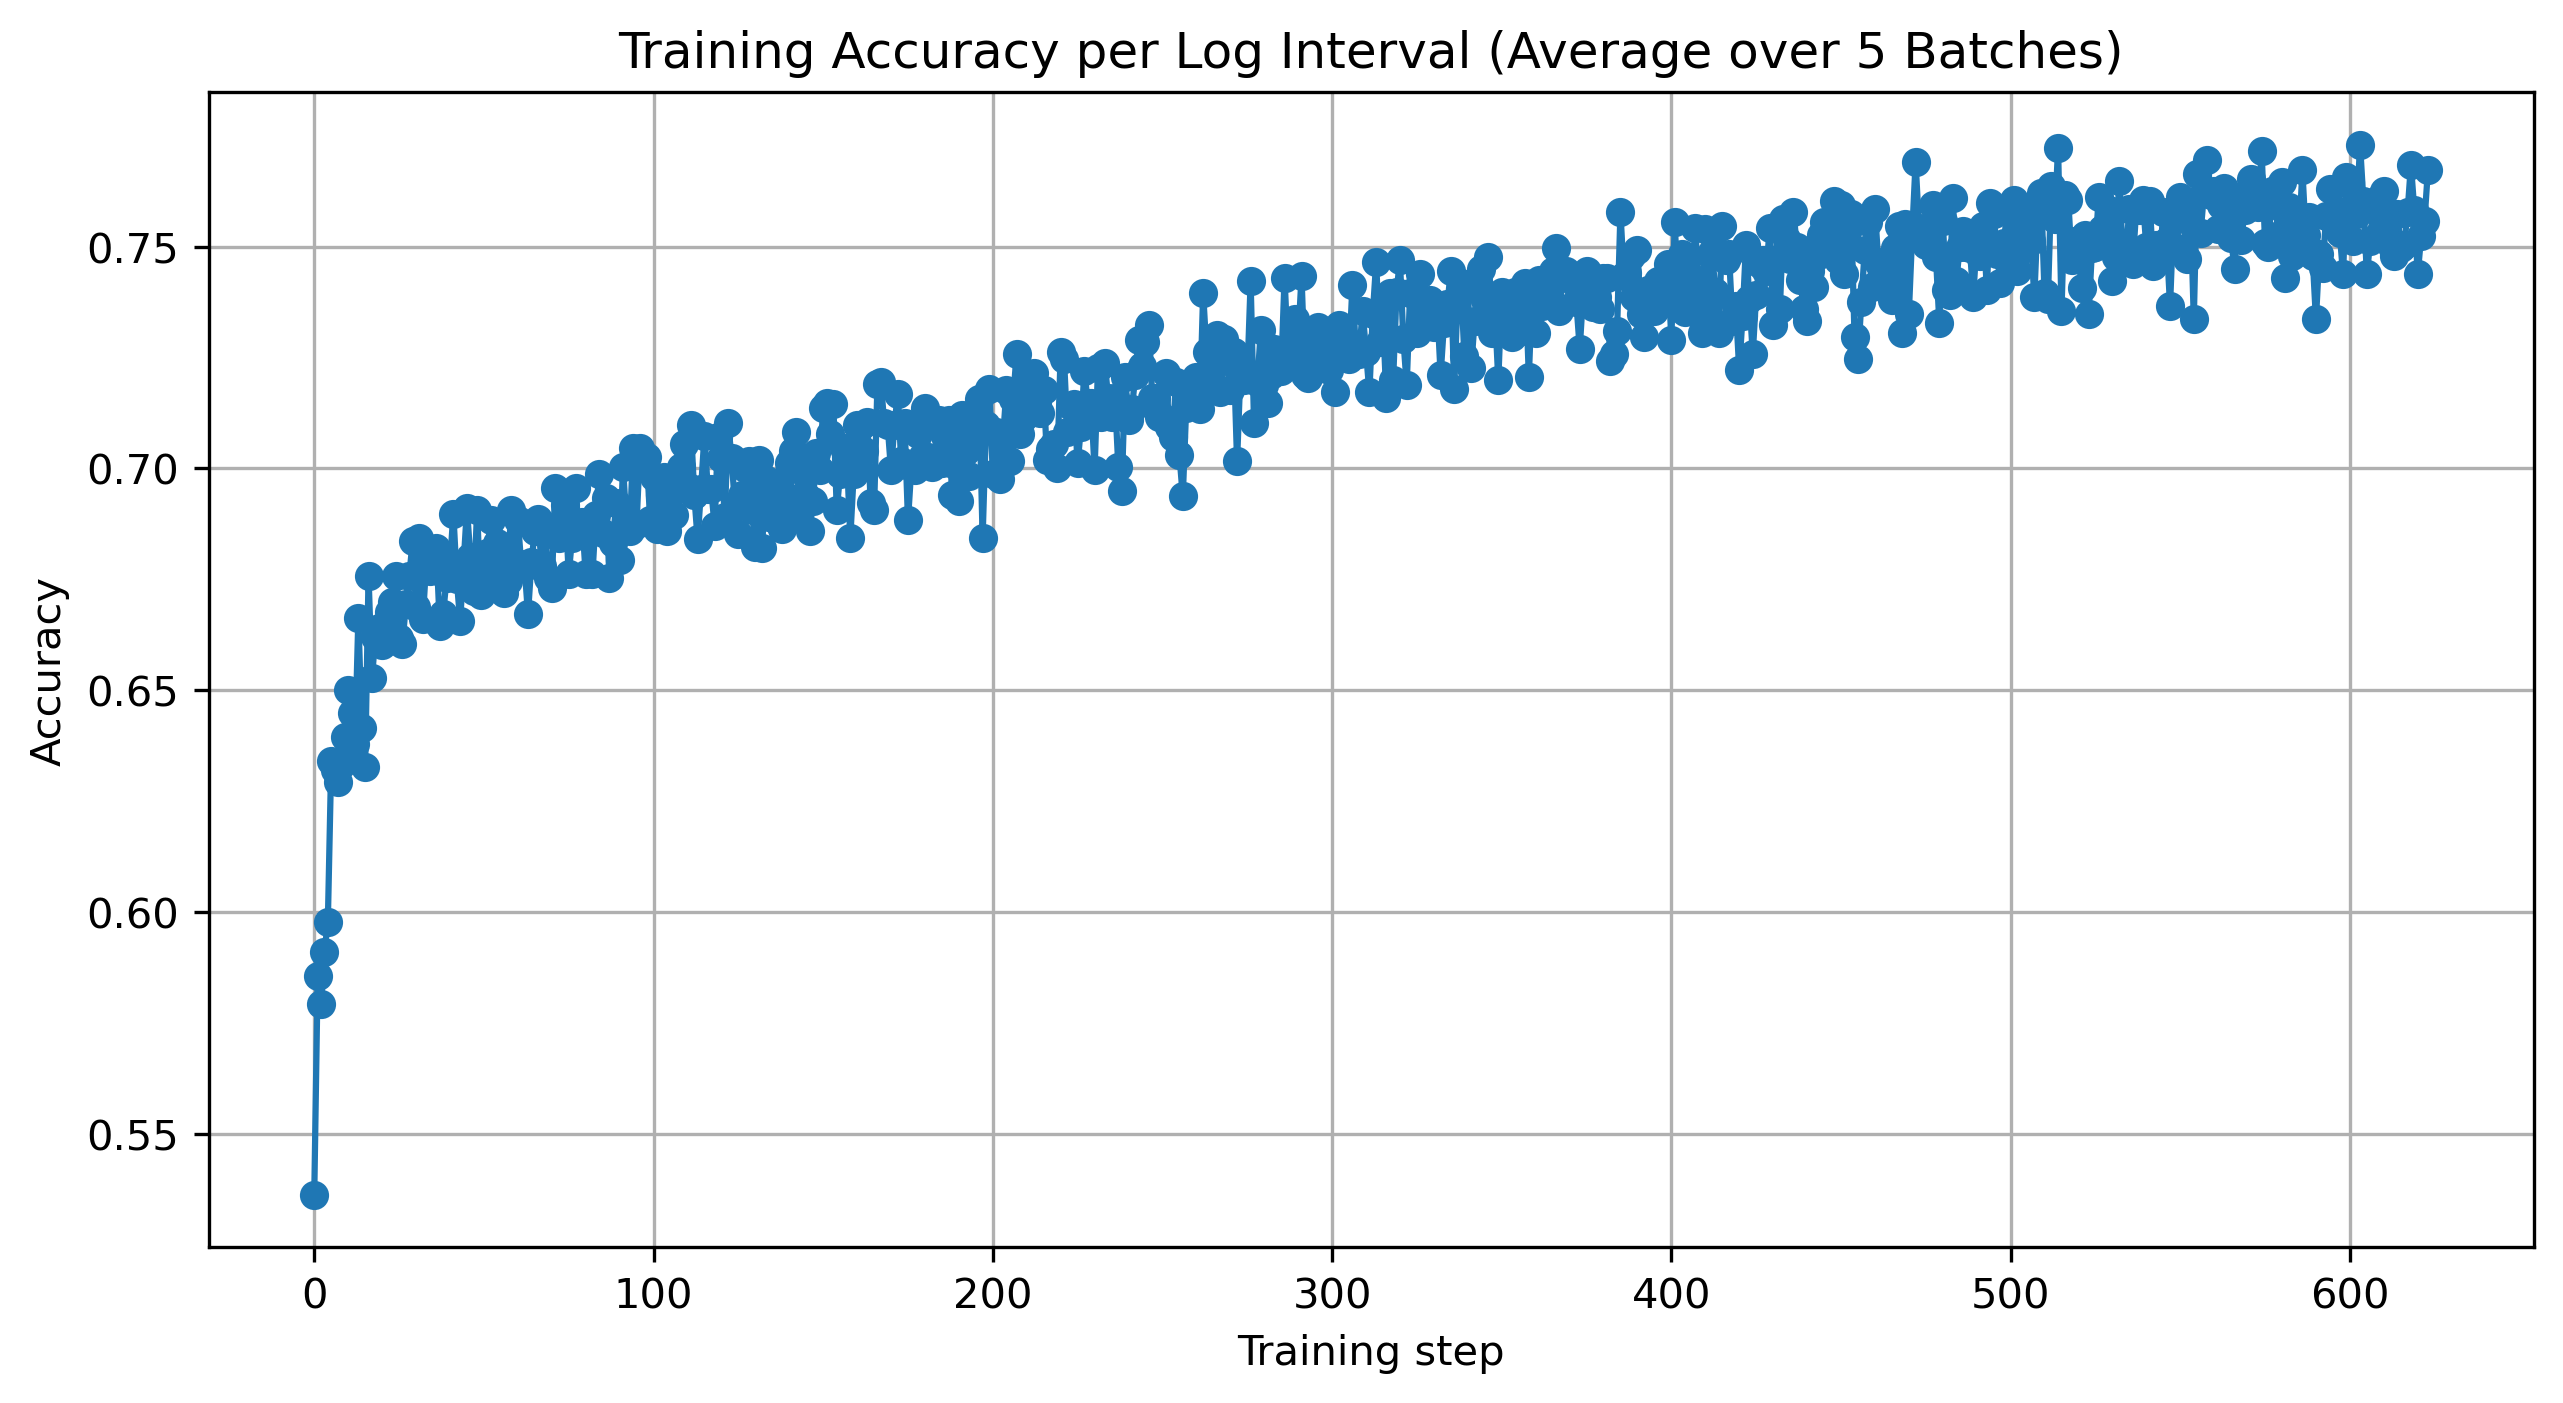

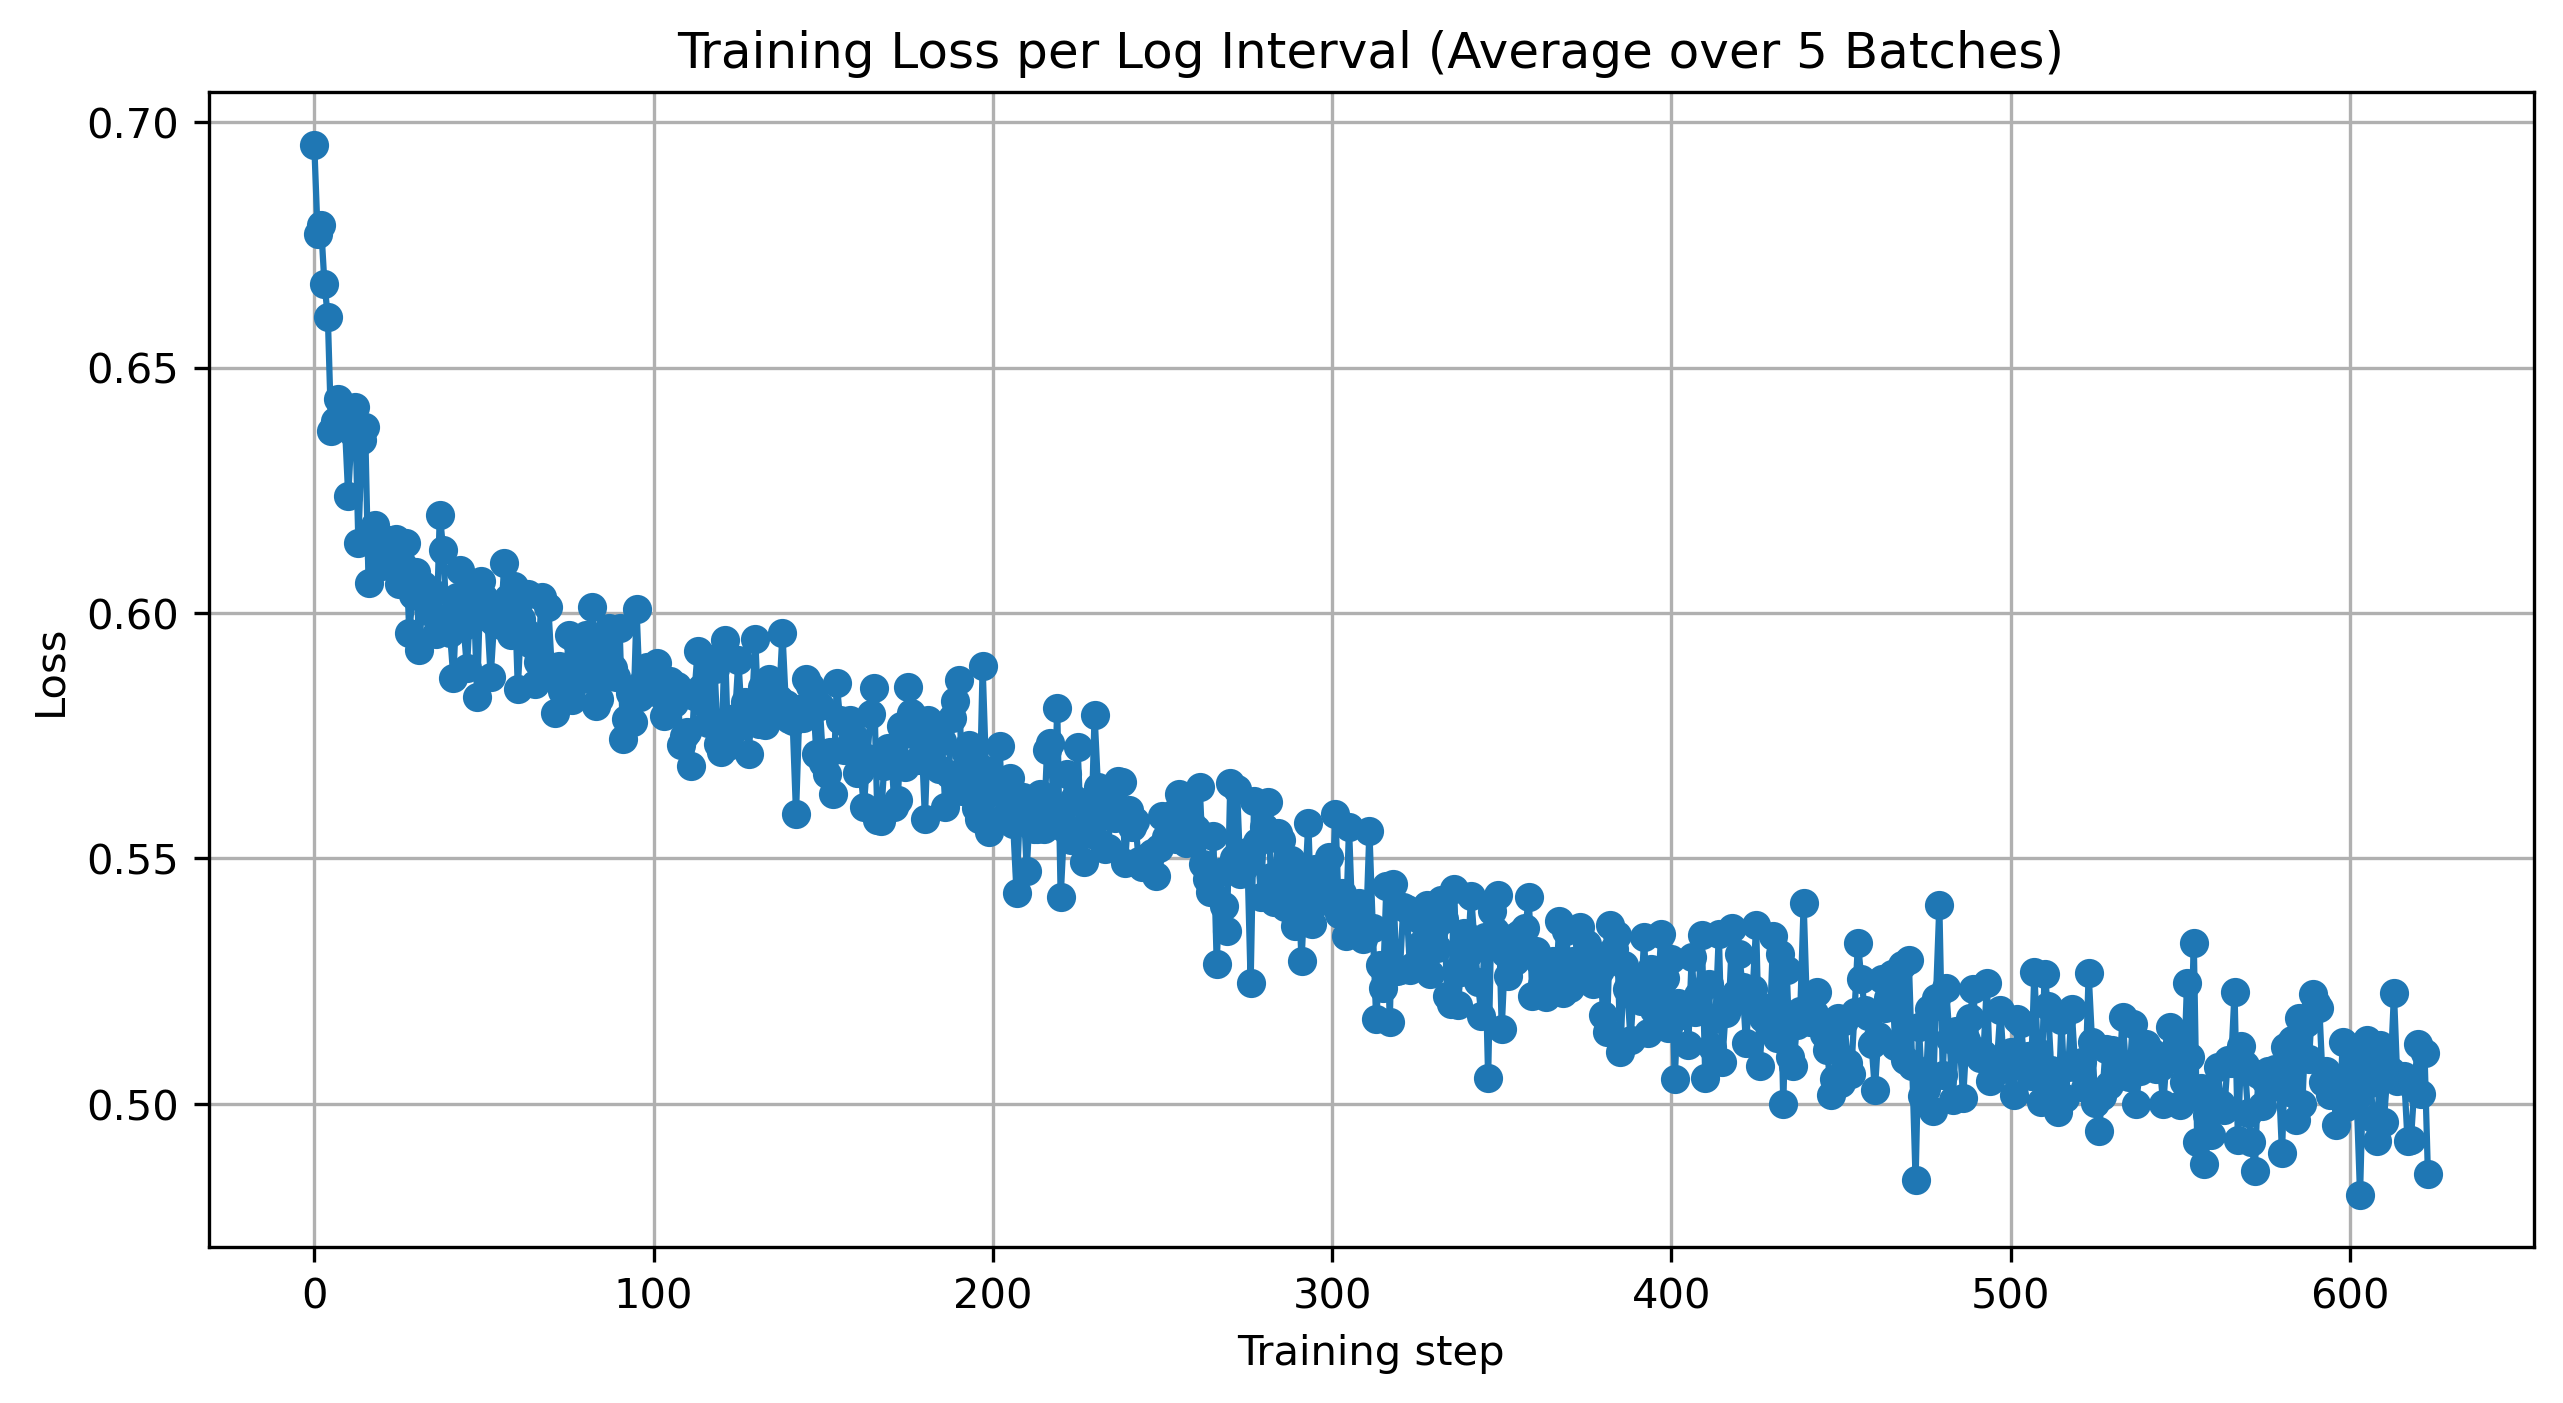

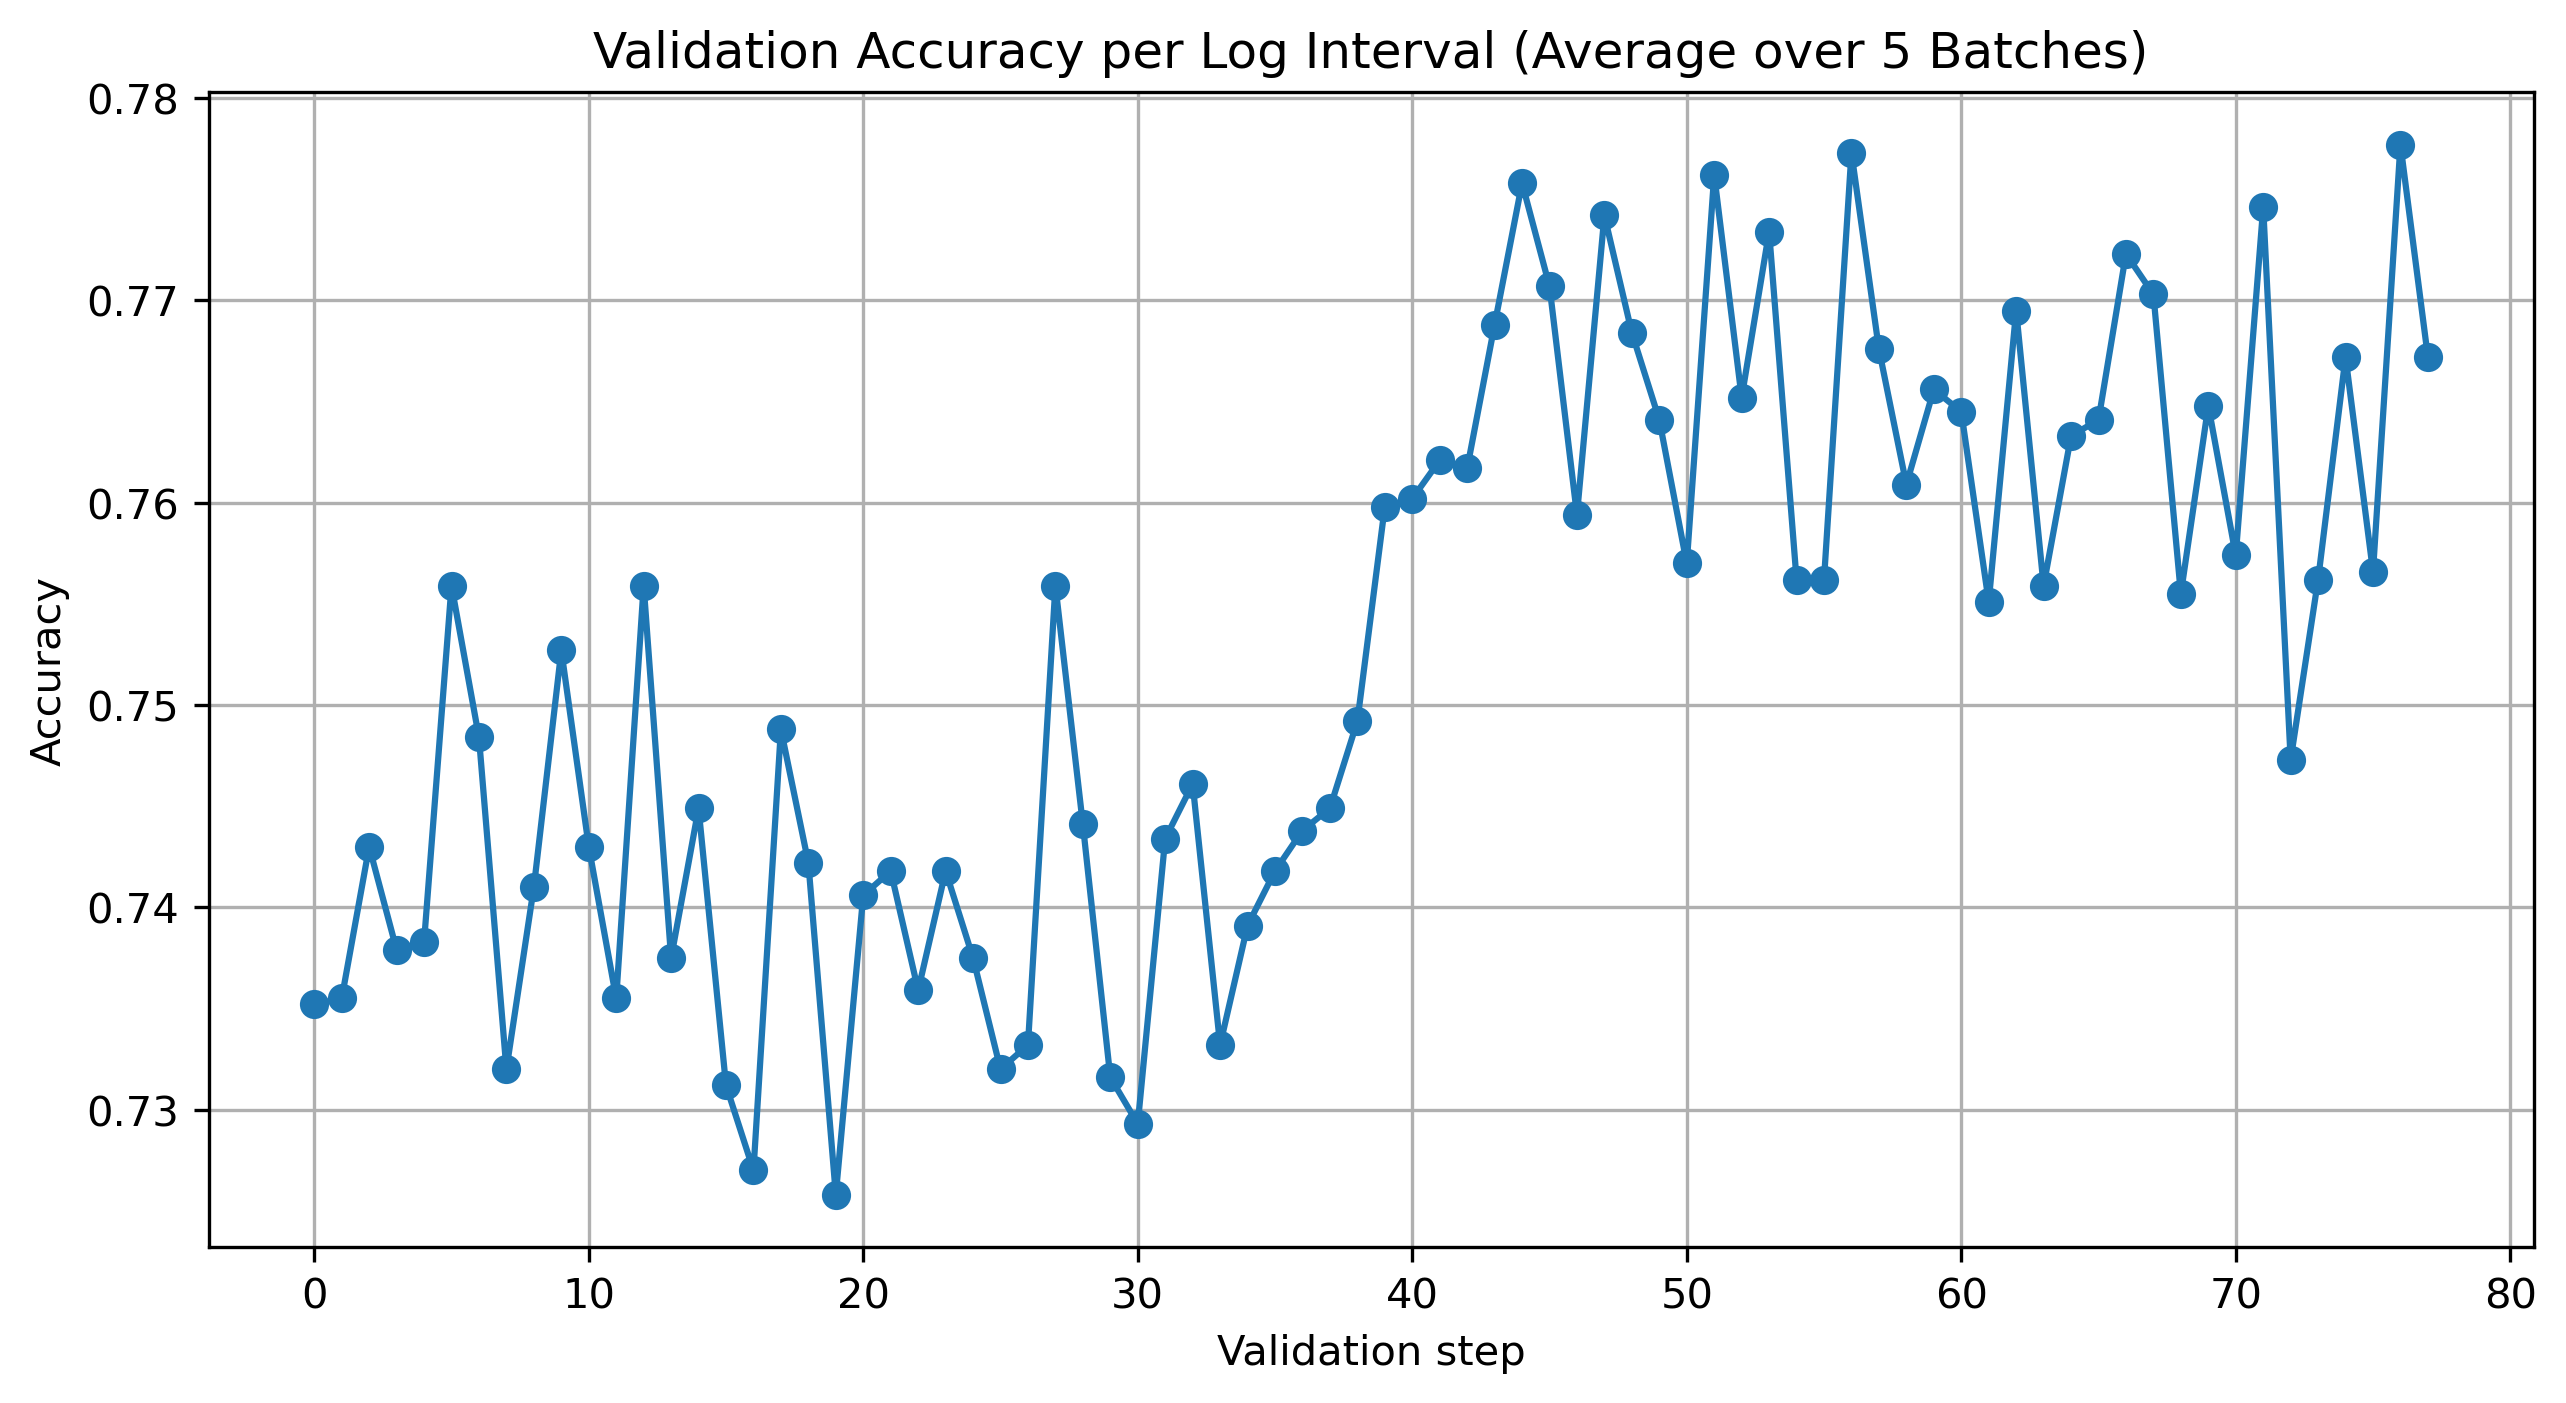

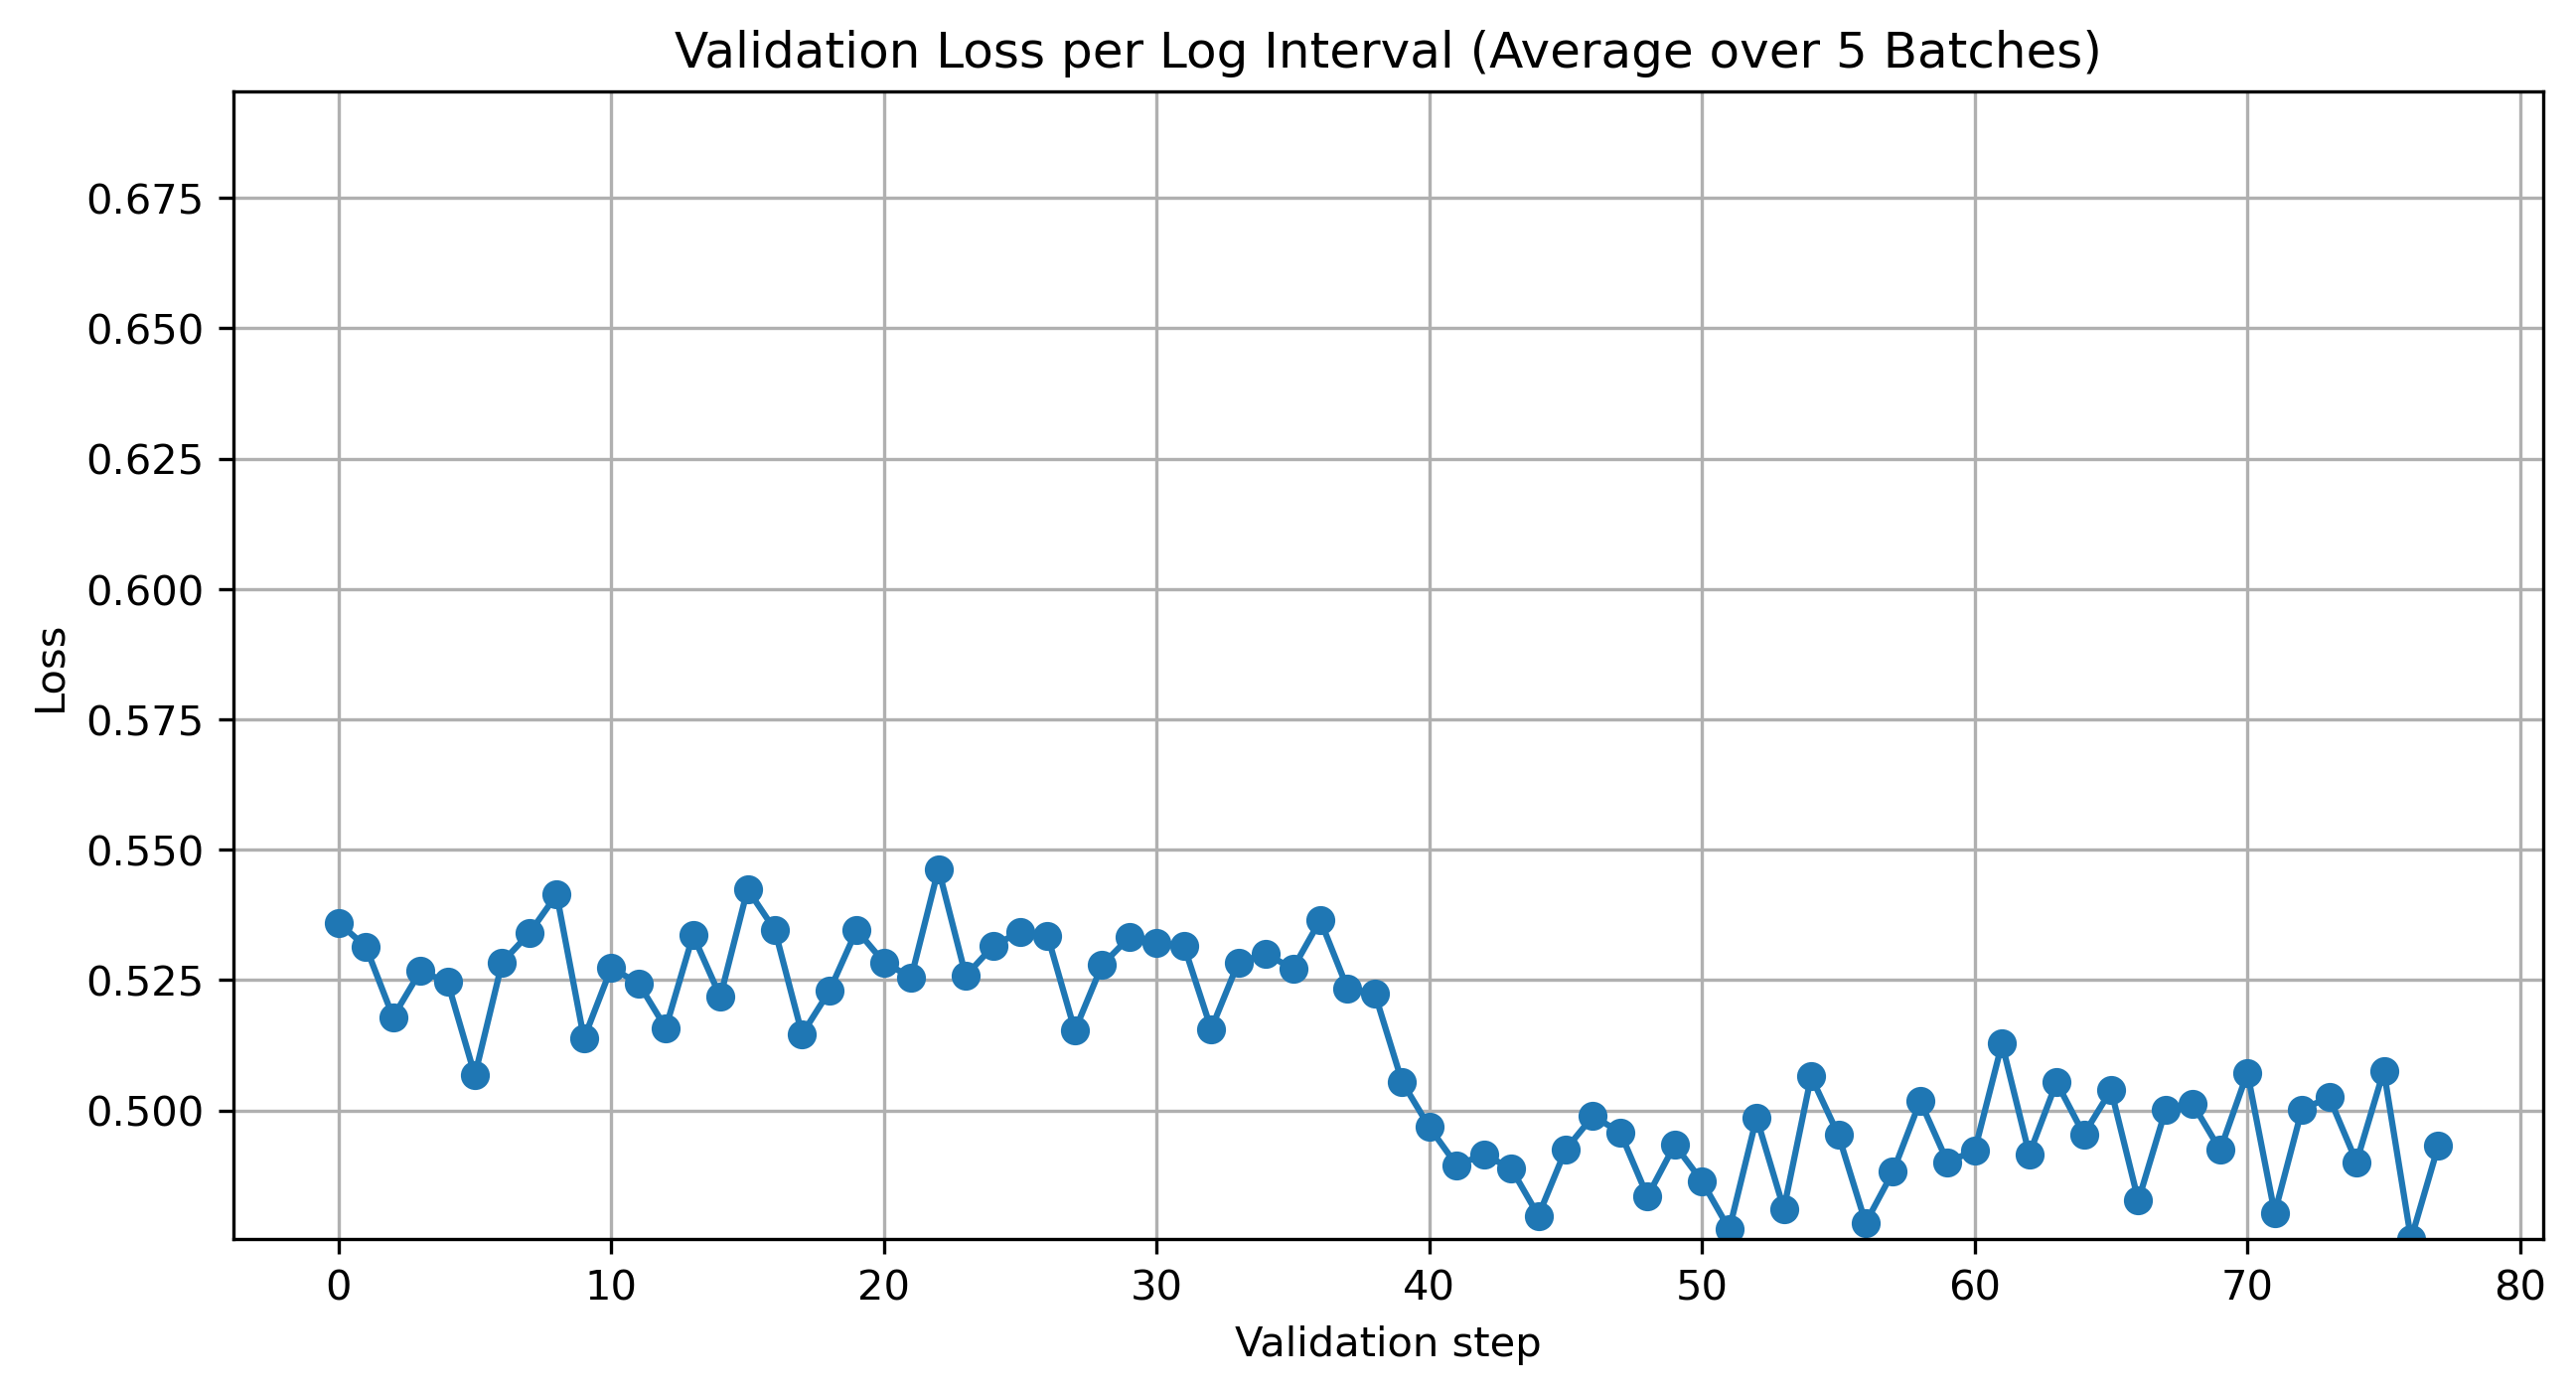

In [28]:
from IPython.display import Image, display
display(Image(filename=f"{log_dir}/train_accuracy.png", width=400))
display(Image(filename=f"{log_dir}/train_loss.png", width=400))
display(Image(filename=f"{log_dir}/val_accuracy.png", width=400))
display(Image(filename=f"{log_dir}/val_loss.png", width=400))

## Step 2: Model Testing 🧪

Now that we've successfully trained our model, the next crucial step in our workflow is to evaluate its performance! This is where we see how well our BINND-like model generalizes to unseen data. 

We can reuse most of the variables and configurations we set up during the training phase. Here's what we'll be using:
- Our dedicated test dataset (test.csv), which you'll find ready in your `data_dir`. This data was held back and never seen by the model during training, so it provides an unbiased evaluation. 
- The trained model (`best_model.pt`) is stored in the `checkpoint_dir`.
- We'll continue to use the same `log_dir` to neatly store all the prediction results and evaluation metrics from this testing phase. 
- It's important to use the same `network_name` and `encoder_name` that were configured during the training phase to ensure compatibility with the trained model.
- We can reuse most of the hyperparameters as well such as `max_seq_length`, and `batch_size`.

The main thing we should change is the following flag 🚩:

In [17]:
is_test = True # We're now in testing mode!

### Launching the Model Testing! 🚀
Similar to our training phase, it's time to assemble all the arguments and generate the command to run our model in testing mode. This command will tell our main.py script to use the trained model on the `test.csv` dataset.

We're carefully building the command line string (`cmd_args`) here, incorporating all the paths, network configurations, and hyperparameters we've defined for testing. Notice that the `is_test` flag 🚩 is now set to `True`!

Once constructed, we'll print the full command for your review and then execute it.


### <span style='background :#FFFFE0' > *A Note on run_experiment.py* 💡 </span> 
All the steps we've walked through in this notebook so far—excluding data preparation—are also combined into a single, convenient script: `run_experiment.py`, located in the `scripts` directory.

We've intentionally kept the variable names in this notebook consistent with those in `run_experiment.py`. This means that once you've understood each step here, you'll find it incredibly easy to follow along with and adapt the more streamlined `run_experiment.py` script for your own experiments!


In [ ]:
cmd_args = [
    "python", f"{ROOT_DIR}/main.py",
    "--data_dir", str(data_dir),
    "--checkpoint_dir", str(checkpoint_dir),
    "--log_dir", str(log_dir),
    "--network_name", network_name,
    "--encoder_name", encoder_name,
    "--max_seq_length", str(max_seq_length),
    "--batch_size", str(batch_size),
    "--is_test"
]

cmd = " ".join(cmd_args)
print(f"Running command:\n{cmd}")
os.system(cmd)

### Testing Results! ✅

After successfully completing the testing phase, your `log_dir` is now updated with new files containing the evaluation results. These will help you analyze the model's performance on unseen data.

You'll find the following new files:
- `roc_curve.csv`: A CSV file containing the data points used to plot the Receiver Operating Characteristic (ROC) curve.
- `roc_curve.png`: A visual representation of the ROC curve, which is a powerful tool for evaluating the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
- `test_log.csv`: A CSV file logging predictions (column named Probability) and ground truth labels (column named Label) for each sample in the test set.
- `test_metrics.json`: A JSON file summarizing key overall performance metrics on the test set, such as accuracy, precision, recall, F1-score, and AUC (Area Under the Curve).
- `confusion_matrix.png`: A visual representation of the confusion matrix, which provides a detailed breakdown of correct and incorrect classifications for each class.

Additionally, the `runtime_info.json` file will have been updated, with execution time and memory consumption from the testing phase appended to it. This helps you keep a comprehensive record of resource usage across different stages of your pipeline.

In [19]:
import pandas as pd

results_df = pd.read_csv(log_dir / 'test_log.csv')
results_df.head()

,Label,Probability
0,1.0,0.365826
1,1.0,0.327636
2,0.0,0.150050
3,1.0,0.192489
4,0.0,0.812269


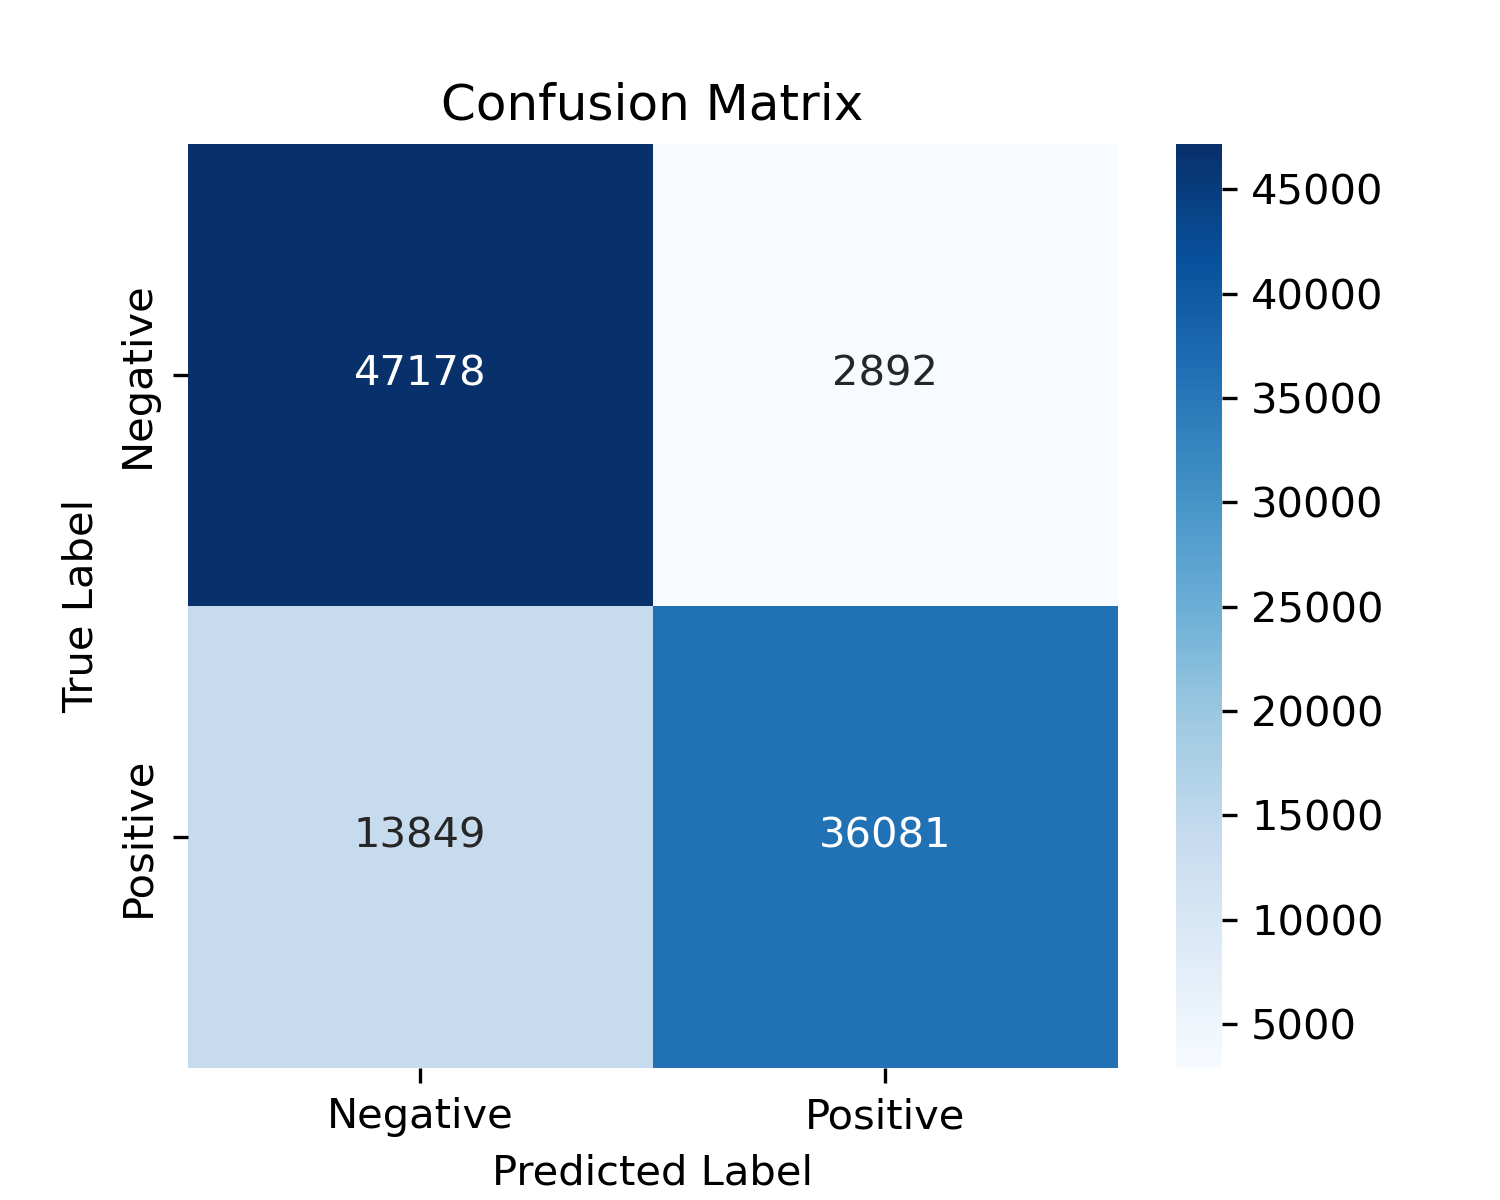

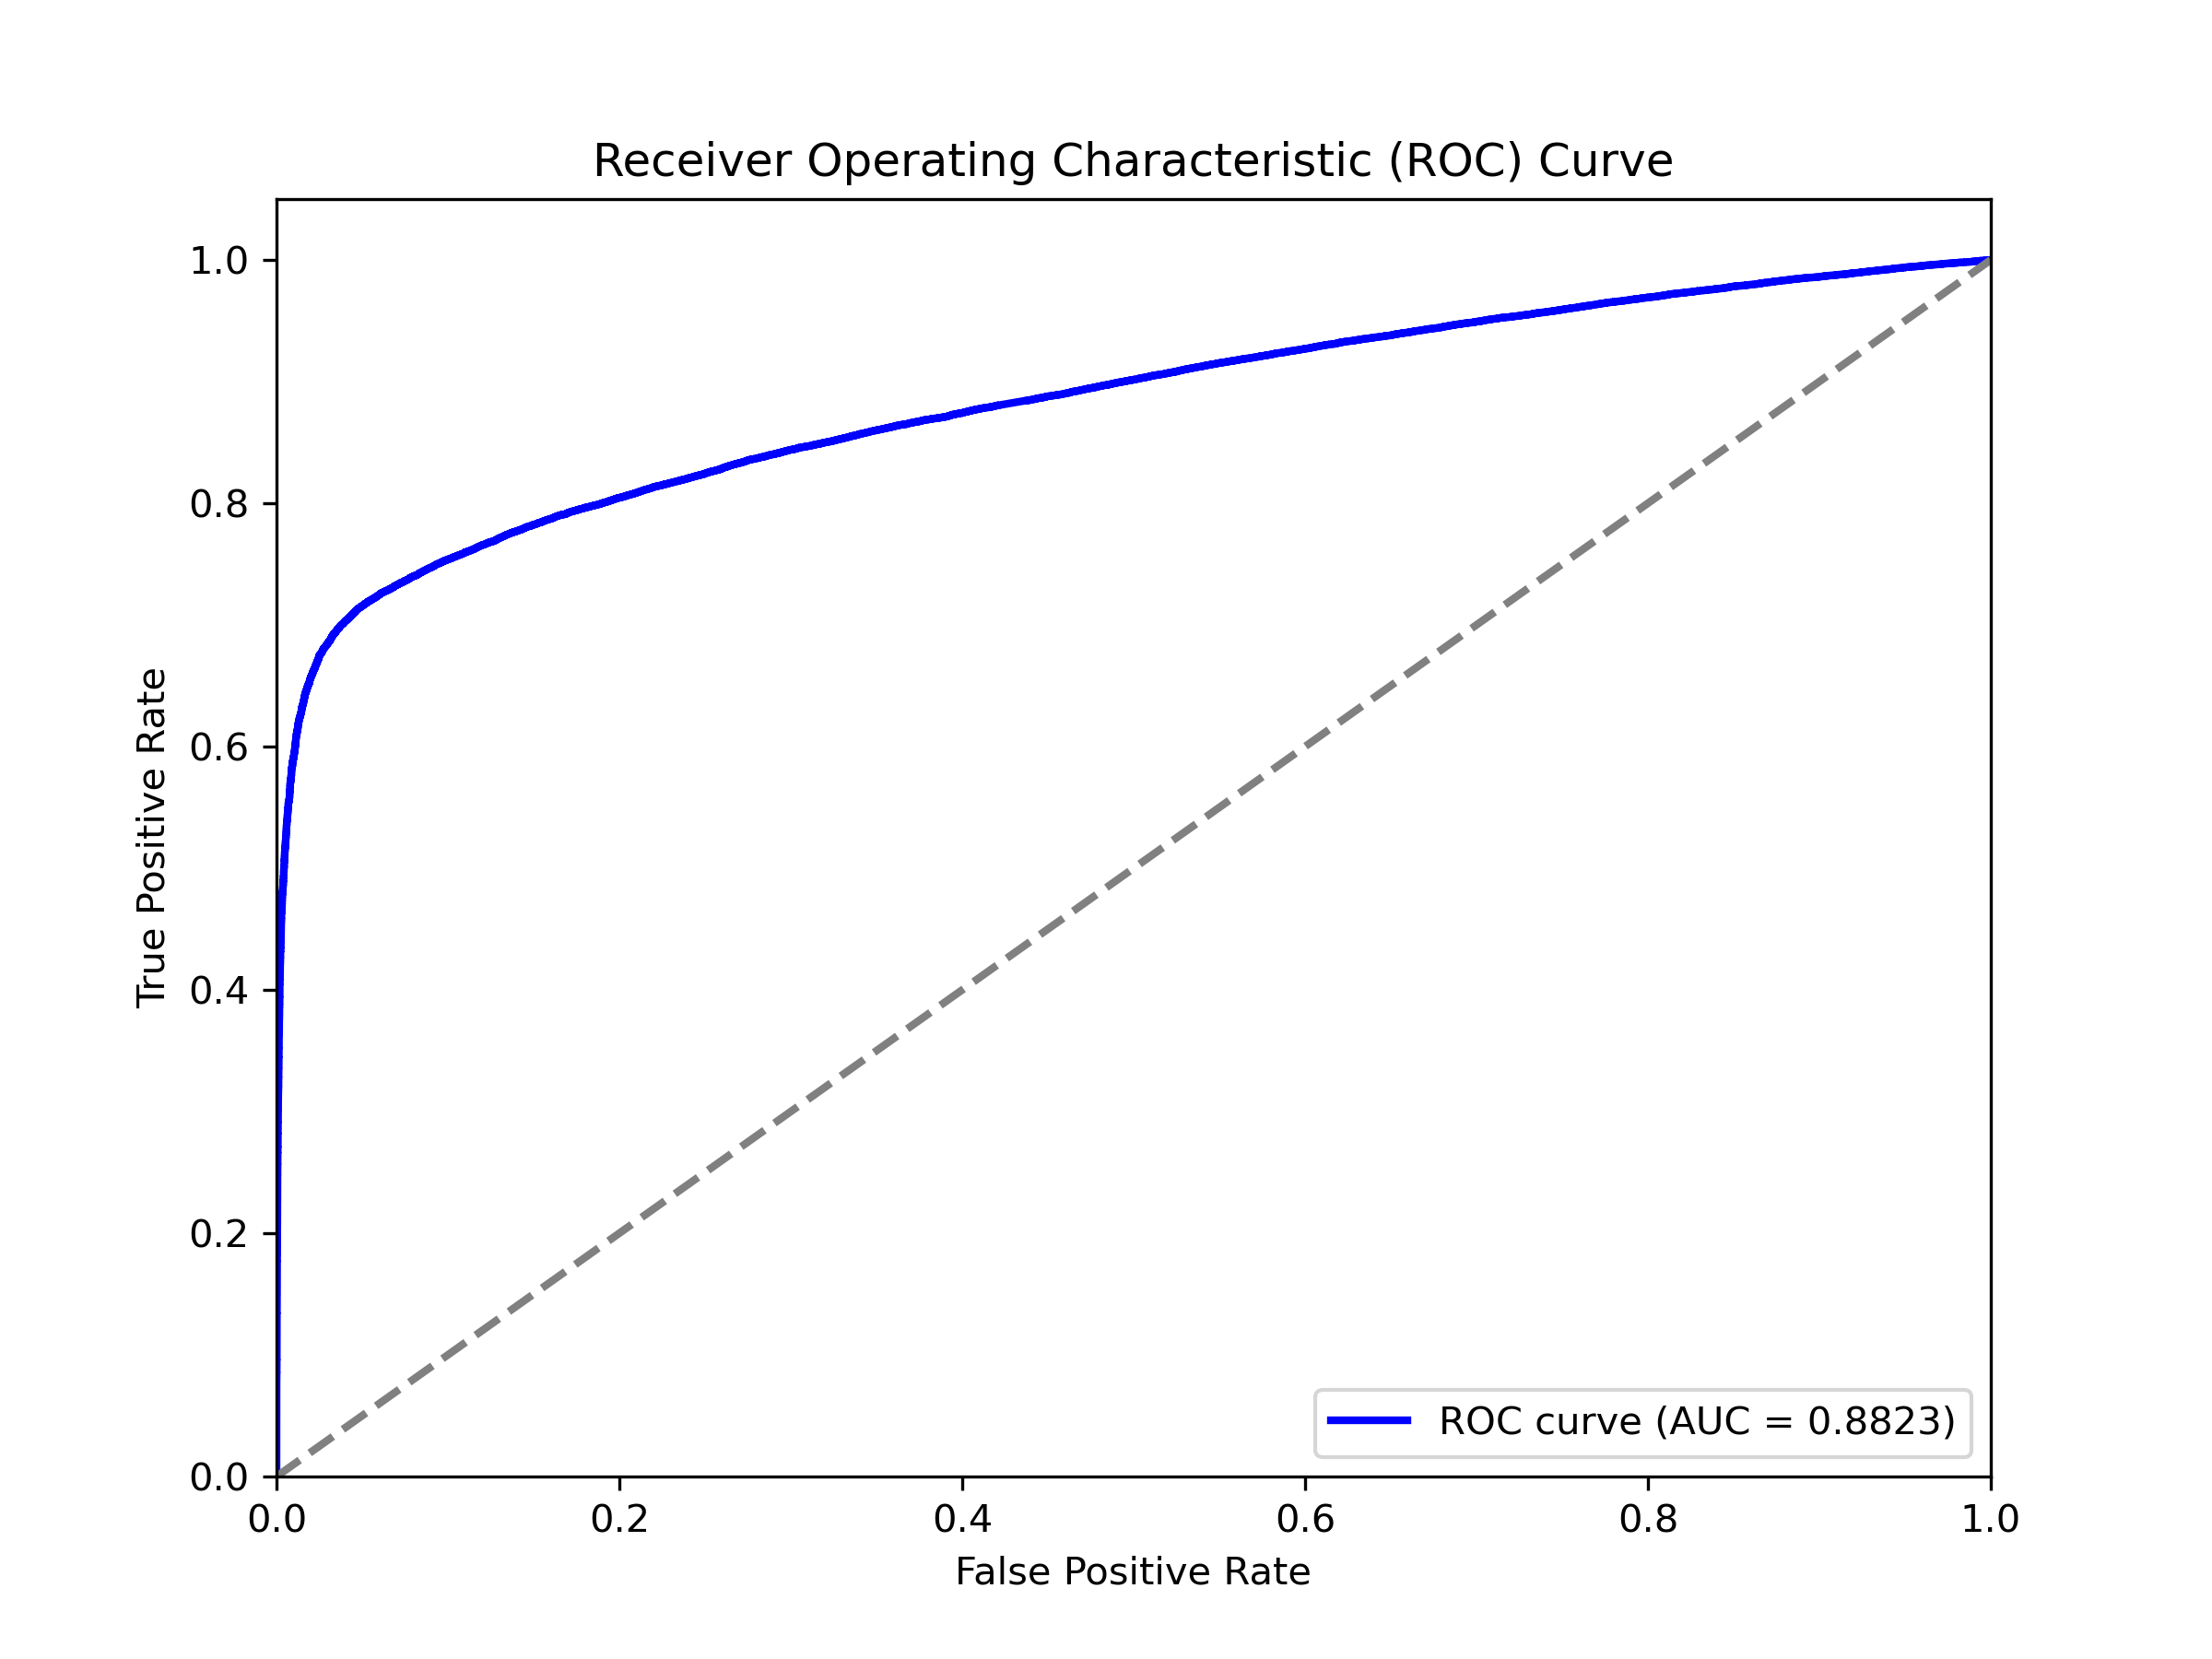

In [25]:
display(Image(filename=f"{log_dir}/confusion_matrix.png", width=400))
display(Image(filename=f"{log_dir}/roc_curve.png", width=400))

With that, we conclude the first major section of our notebook! You've successfully walked through the entire process of training and evaluating your own BINND-like model, from preparing your data to understanding the results.

---

## Testing BINND on your Own Dataset

So, you've got your own dataset and want to see how the powerful BINND model performs on it? This section is designed to guide you through exactly that process.

We've made it easy for you to access the pre-trained BINND models from our paper. You'll find:
- The BINND model here: `experiments/checkpoints/BINND/best_model.pt`
- The BINND-Lite model here: `experiments/checkpoints/BINNDLite/best_model.pt`

As a first step, let's get our directories set up. We'll assume you want to neatly store all the testing results (i.e., logs and predictions) in a new directory called `my_test`. 

In [21]:
import os
data_dir = ROOT_DIR / 'data' / 'demo'
checkpoint_dir = ROOT_DIR / 'experiments' / 'checkpoints' / 'BINND'
log_dir = ROOT_DIR / 'experiments' / 'logs' / 'my_test'

# Check if data directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Data directory does not exist: {data_dir}")
if not os.path.exists(checkpoint_dir):
    raise FileNotFoundError(f"Checkpoint directory does not exist: {checkpoint_dir}")

# Create directories if they don't exist
os.makedirs(log_dir, exist_ok=True)

The rest of the testing process will be exactly the same as what we covered in "Step 2: Model Testing" above.

You'll configure the necessary flags (like is_test = True), assemble the command line arguments, and then execute the script to run the inference. The output logs and evaluation files will be generated in your newly specified log_dir (my_test in this case), just as before.

In [ ]:
# configure the network and encoder names
network_name = "BINND"
encoder_name = "4xn_v2"

# set the is_test flag to True
is_test = True

# set the parameters for testing
max_seq_length = 20
batch_size = 512

# Prepare the command to run the inference
cmd_args = [
    "python", f"{ROOT_DIR}/main.py",
    "--data_dir", str(data_dir),
    "--checkpoint_dir", str(checkpoint_dir),
    "--log_dir", str(log_dir),
    "--network_name", network_name,
    "--encoder_name", encoder_name,
    "--max_seq_length", str(max_seq_length),
    "--batch_size", str(batch_size),
    "--is_test"
]

cmd = " ".join(cmd_args)
print(f"Running command:\n{cmd}")
os.system(cmd)

---

## Prediction and Deeper Analysis 📈
While the evaluation metrics (like accuracy, F1-score, and AUC) generated by the model are excellent for understanding its generalizability, our analysis doesn't have to stop there!

There are further steps we can take, leveraging the actual predictions made by the model, to gain even more valuable insights and understand our model's behavior better.

### 1. Prediction probability distribution